In [ ]:
# calc and draw AUC/ROCs + boxplots
# use log2 transform of molecule count
# also calc. risk at 1 IQR change

In [2]:
library(pROC) # roc curve
library(readxl)
library(gridExtra)
library(ggplot2)

In [3]:
setwd("..")

In [4]:
sampleAnnotFile = "annotation/annotation-78.csv"
pcrValueFile = "data/PCR/PCR-measurement_78.xlsx"
outDir = "Figures-and-Tables/"
table4outfile="Table-4-AUC-ROC-results.csv"
figure5outfile = "Figure-5-AUC-ROC.svg"
tableS5outfile = "SupplTable-S5-two-gene-combinations.csv"

In [5]:
# sample annotation
annot = read.csv(file = sampleAnnotFile ,header = T,sep = "\t",stringsAsFactors = F)
annot$gender = ifelse(annot$gender=="f","female","male")
head(annot,3)

,ID,gender,age,group
,<chr>,<chr>,<int>,<chr>
1,SXR0002,female,80,ccRCC
2,SXR0004,male,50,ccRCC
3,SXR0006,male,68,ccRCC


### read in PCR data
and normalize molec. counts to house keeping gene

In [6]:
pcr = as.data.frame(read_excel(path = pcrValueFile, sheet = 1))
pcr$SNORD99_ACTB_mol = pcr$SNORD99_molec_count/pcr$ACTB_molec_count
pcr = pcr[,c("ID","SNORD99_ACTB_mol")]
head(pcr,2)

,ID,SNORD99_ACTB_mol
,<chr>,<dbl>
1,SXR0002,0.25324223
2,SXR0004,0.09088467


In [7]:
tmp = as.data.frame(read_excel(path = pcrValueFile, sheet = 2))
tmp$SNORD22_RNY3_mol = tmp$SNORD22_molec_count/tmp$RNY3_molec_count
tmp$SNORD26_RNY3_mol = tmp$SNORD26_molec_count/tmp$RNY3_molec_count
tmp = tmp[,c("ID","SNORD22_RNY3_mol","SNORD26_RNY3_mol")]
pcr = merge(pcr,tmp,by="ID")
head(pcr,2)

,ID,SNORD99_ACTB_mol,SNORD22_RNY3_mol,SNORD26_RNY3_mol
,<chr>,<dbl>,<dbl>,<dbl>
1,SXR0002,0.25324223,Inf,NaN
2,SXR0004,0.09088467,0.06216743,0.01914862


In [8]:
tmp = as.data.frame(read_excel(path = pcrValueFile, sheet = 3))
tmp$SNORA50C_ACTB_mol = tmp$SNORA50C_molec_count / tmp$ACTB_molec_count
tmp = tmp[,c("ID","SNORA50C_ACTB_mol")]
pcr = merge(pcr,tmp,by="ID")
head(pcr,3)

,ID,SNORD99_ACTB_mol,SNORD22_RNY3_mol,SNORD26_RNY3_mol,SNORA50C_ACTB_mol
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SXR0002,0.25324223,Inf,NaN,0.021118913
2,SXR0004,0.09088467,0.06216743,0.01914862,0.004867978
3,SXR0006,0.02808557,0.03330643,0.01758783,0.012005747


In [9]:
pcr = merge(x = pcr,y=annot, by = "ID", all.y=F)
pcr$SNORD99_ACTB_mol[which(is.infinite(pcr$SNORD99_ACTB_mol) | is.nan(pcr$SNORD99_ACTB_mol))] = NA
pcr$SNORD22_RNY3_mol[which(is.infinite(pcr$SNORD22_RNY3_mol) | is.nan(pcr$SNORD22_RNY3_mol))] = NA
pcr$SNORD26_RNY3_mol[which(is.infinite(pcr$SNORD26_RNY3_mol) | is.nan(pcr$SNORD26_RNY3_mol))] = NA
pcr$SNORA50C_ACTB_mol[which(is.infinite(pcr$SNORA50C_ACTB_mol) | is.nan(pcr$SNORA50C_ACTB_mol))] = NA
head(pcr,3)

,ID,SNORD99_ACTB_mol,SNORD22_RNY3_mol,SNORD26_RNY3_mol,SNORA50C_ACTB_mol,gender,age,group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,SXR0002,0.25324223,NA,NA,0.021118913,female,80,ccRCC
2,SXR0004,0.09088467,0.06216743,0.01914862,0.004867978,male,50,ccRCC
3,SXR0006,0.02808557,0.03330643,0.01758783,0.012005747,male,68,ccRCC


In [10]:
pcr$group_binary = factor(x = pcr$group, levels = c("urolithiasis","ccRCC"))
rownames(pcr) = pcr$ID

In [11]:
glmRocBox = function(dat, var = "SNORA50C_ACTB_mol", label = "SNORA50C / ACTB", log=F ) {
    if(log) { # logarithmize
        dat$var_log = log(dat[,var] + min(setdiff(dat[,var],0), na.rm = T)/2) # pseudo count to avoid log(0)
        formula = as.formula(paste0("group_binary ~ var_log + gender + age"))
    } else {
        formula = as.formula(paste0("group_binary ~ ",var," + gender + age"))
    }
    wh = which(!is.na(dat$var_log))
    dat = dat[wh,]
    glmModel = glm(data = dat,formula = formula, family = "binomial")
    pVal = summary(glmModel)$coefficients[2,c("Pr(>|z|)")]
    pVal
    testProb = predict(glmModel, newdata = dat, type = "response") 
    testRoc = roc(group_binary ~ testProb, data = dat , plot = F, print.auc = TRUE, 
                  print.auc.cex=1.2, main = label, cex.main=0.9)
    iqr = unname(diff(quantile(dat$var_log,c(0.25,0.75))))
    OR_iqr = exp(glmModel$coefficients[2] * iqr)

    ci = exp(confint(glmModel,"var_log") * iqr)
    
    
    YoudenIdx = testRoc$sensitivities + testRoc$specificities - 1
    wh = which(YoudenIdx == max(YoudenIdx))
    if(length(wh)>1) {
        message("there are several maximal Youden indeces for ",var," !")
    }
    sens = testRoc$sensitivities[wh]
    spec = testRoc$specificities[wh] # max sens and spec combined;
    # accuracy = sensitivity * prevalence + specif*(1-prevalence)
    prev = length(which(dat$group_binary=="ccRCC"))/nrow(dat)
    prev
    accuracy = sens*prev + spec*(1-prev)
    
    results <<- rbind( results,
              data.frame(gene = label,sens = sens, spec=spec, acc = accuracy, AUC=testRoc$auc, 
                         OR_iqr = OR_iqr, CI1=ci[1],CI2=ci[2],p=pVal, stringsAsFactors = F))
    
    pRoc = ggroc(testRoc)  + 
        annotate(geom = "text",x=0.5,y=0.3, hjust=0,
                  label=paste0("p = ",round(pVal,4),"\nAUC = ",round(testRoc$auc,3),
                               "\nsensitivity = ",round(sens,2),
                               "\nspecificity = ",round(spec,2) ) )
    
    segmData = data.frame(x1 = 1, x2 = 0, y1 = 0, y2 = 1)
    pRoc = pRoc + geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), color = "grey", linetype=2, data = segmData)
    
    dat$boxplVar = dat[,var]
    pBox = ggplot(data = dat, mapping = aes(x = group, y = boxplVar, fill=group)) + geom_boxplot() + 
        scale_fill_manual(values = c("red", "blue")) + xlab("") + ylab("") + 
                    theme(legend.position="none", axis.text.x = element_text(angle = 30, hjust=1,vjust=1), 
                         plot.margin = unit(c(5.5,5.5,5.5,5.5), "pt")) + 
            scale_y_log10() 
    return(list(pRoc,pBox))
}

In [12]:
plots = list()
results = NULL
plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORD99_ACTB_mol", label = "SNORD99", log = T)
names(plots)[length(plots)] = "SNORD99"

plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORD22_RNY3_mol", label = "SNORD22", log = T)
names(plots)[length(plots)] = "SNORD22"

plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORD26_RNY3_mol", label = "SNORD26", log = T)
names(plots)[length(plots)] = "SNORD26"

plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORA50C_ACTB_mol", label = "SNORA50C", log = T)
names(plots)[length(plots)] = "SNORA50C"

results

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...



,gene,sens,spec,acc,AUC,OR_iqr,CI1,CI2,p
,<chr>,<dbl>,<dbl>,<dbl>,<auc>,<dbl>,<dbl>,<dbl>,<dbl>
var_log,SNORD99,0.6666667,0.6250000,0.6538462,0.6813272,0.3835543,0.13875497,0.9098473,0.04264545
var_log1,SNORD22,0.5000000,0.8750000,0.6285714,0.7038043,0.5596344,0.30503608,0.9276822,0.03750403
var_log2,SNORD26,0.7608696,0.6666667,0.7285714,0.6766304,0.5726766,0.30439260,0.9819019,0.05776943
var_log3,SNORA50C,0.7777778,0.6666667,0.7435897,0.7353395,0.2104662,0.05430138,0.6093736,0.01076228


## Table 4

In [13]:
write.table(x = results, file = paste0(outDir,table4outfile),quote = F,sep = "\t",row.names = F)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing non-finite values (`stat_boxplot()`).”


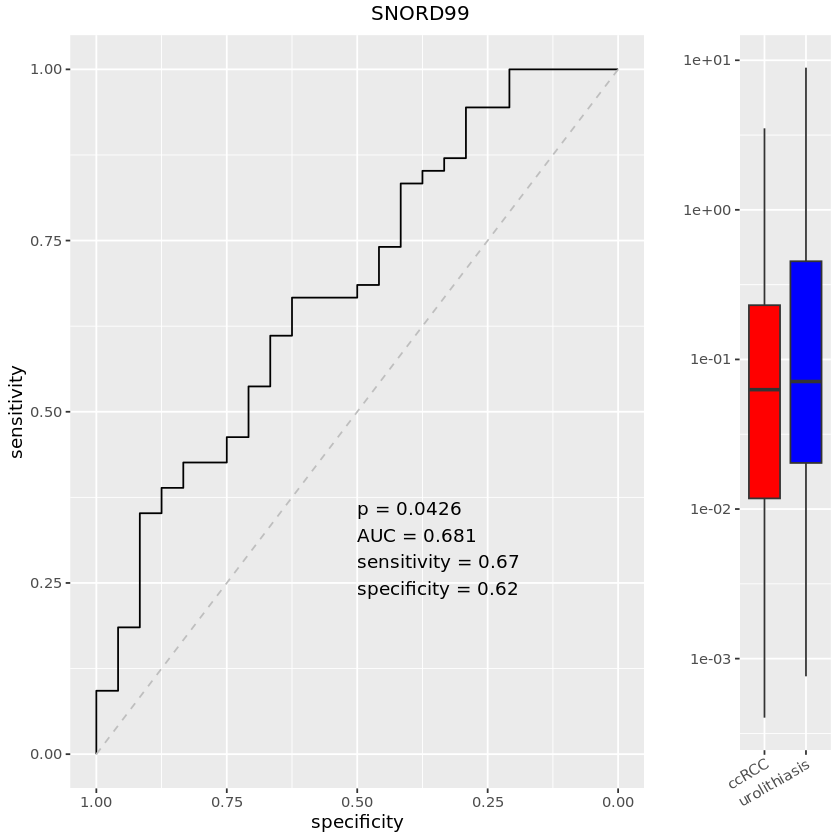

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”


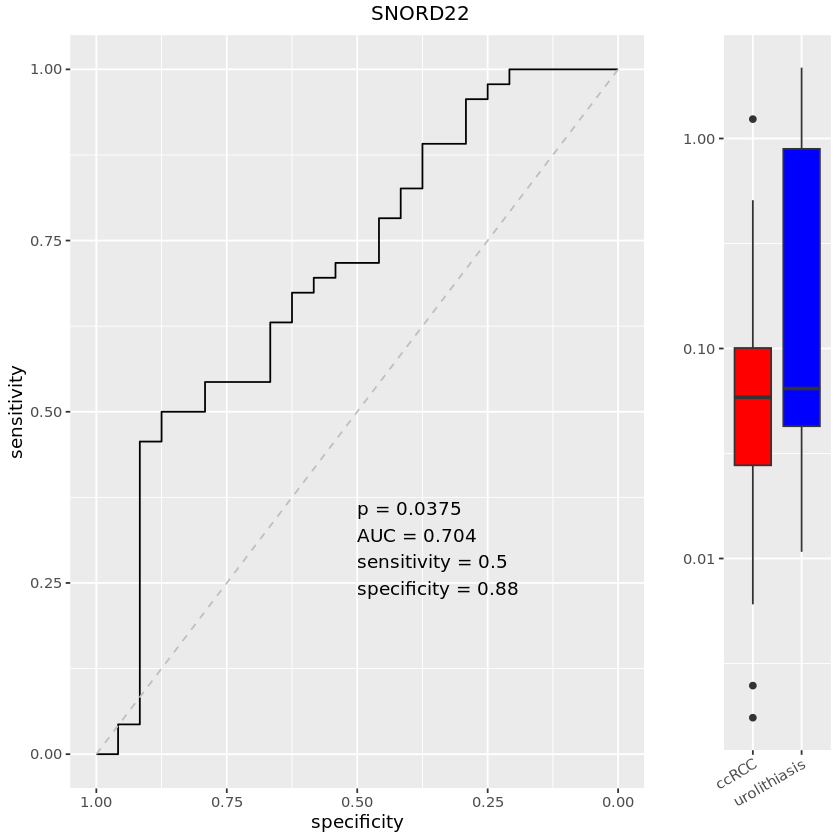

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


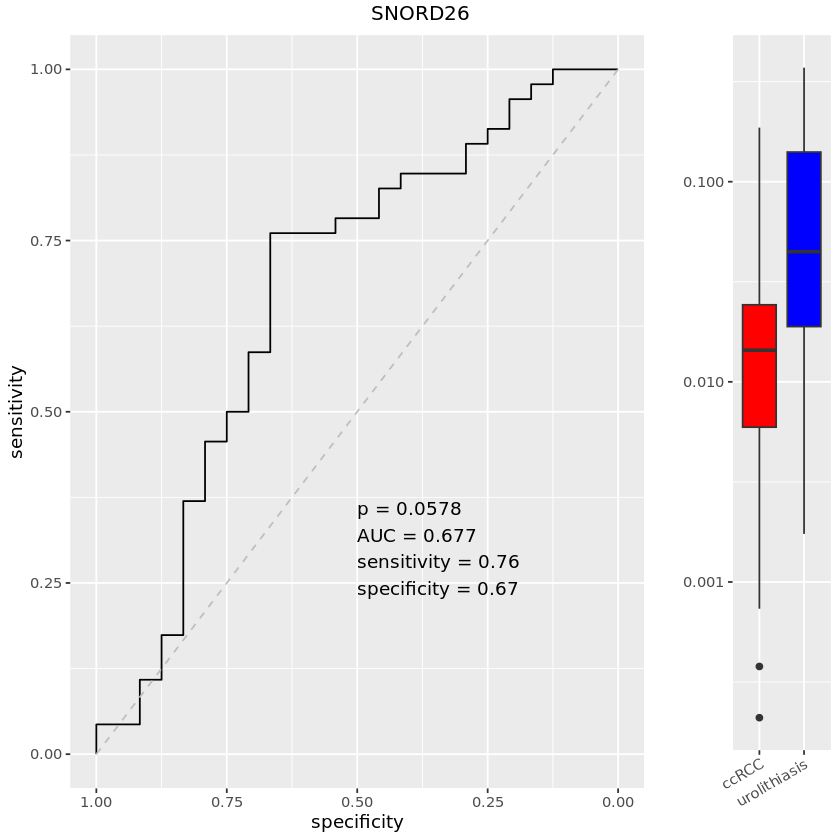

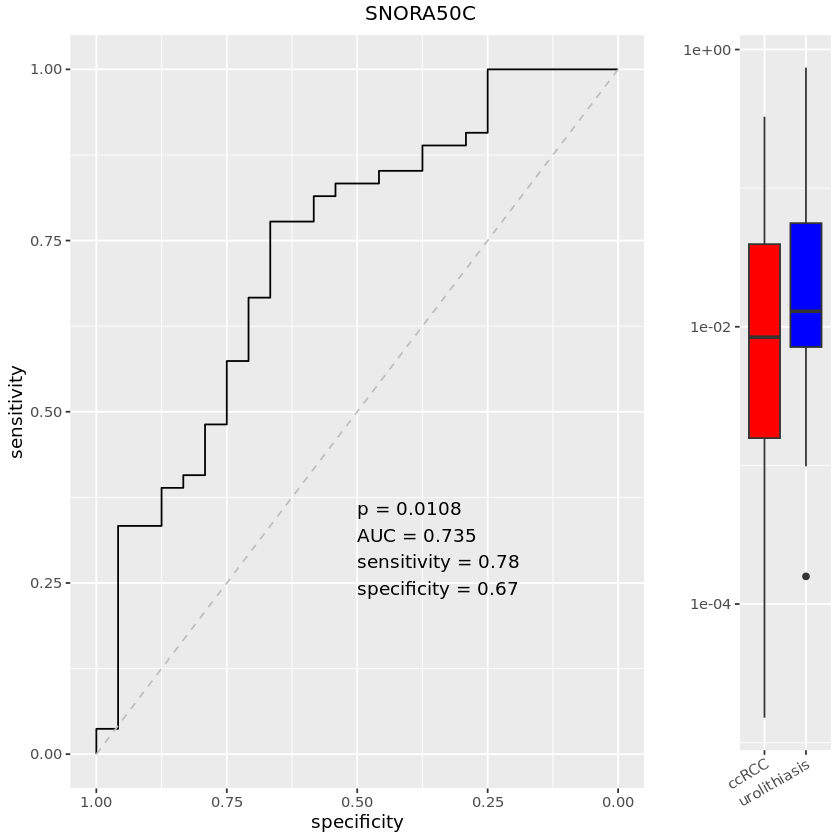

In [14]:
for(i in 1:length(plots)) {
    grid.arrange(plots[[i]][[1]], plots[[i]][[2]], ncol=2, widths=c(3.5,1),top=names(plots)[i])
}

# Figure 5

In [15]:
svg(filename = paste0(outDir,figure5outfile), width=12,height=12)
grid.arrange(plots[[1]][[1]], plots[[1]][[2]], plots[[2]][[1]], plots[[2]][[2]], 
             plots[[3]][[1]], plots[[3]][[2]], plots[[4]][[1]], plots[[4]][[2]], 
             ncol=4, widths=c(3.5,1,3.5,1))
dev.off()

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

## combinations of 2 genes

In [16]:
glmRocBox2genes = function(dat, var1 = "SNORD99_ACTB_mol", var2 = "SNORD22_RNY3_mol", 
                           label1 = "SNORD99", label2 = "SNORD22", label = "SNORD99 / SNORD22", log=F ) {
    if(log) { # logarithmize
        dat$var1_log = log(dat[,var1] + min(setdiff(dat[,var1],0), na.rm = T)/2)
        dat$var2_log = log(dat[,var2] + min(setdiff(dat[,var2],0), na.rm = T)/2)
        formula = as.formula(paste0("group_binary ~ var1_log + var2_log + gender + age"))
    } else {
        formula = as.formula(paste0("group_binary ~ ",var1," + ", var2, " + gender + age"))
    }
       
    wh = which(! (is.na(dat$var1_log) | is.na(dat$var2_log)) )
    dat = dat[wh,]
    glmModel = glm(data = dat,formula = formula, family = "binomial")
    pValA = summary(glmModel)$coefficients[2,c("Pr(>|z|)")]
    pValB = summary(glmModel)$coefficients[3,c("Pr(>|z|)")]
    
    testProb = predict(glmModel, newdata = dat, type = "response") 
    testRoc = roc(group_binary ~ testProb, data = dat , plot = F, print.auc = TRUE, 
                  print.auc.cex=1.2, main = label, cex.main=0.9)
    
    iqrA= unname(diff(quantile(dat$var1_log,c(0.25,0.75))))
    OR_iqrA = exp(glmModel$coefficients[2] * iqrA)
    ciA = exp(confint(glmModel,"var1_log") * iqrA)
    
    iqrB = unname(diff(quantile(dat$var2_log,c(0.25,0.75))))
    OR_iqrB = exp(glmModel$coefficients[3] * iqrB)
    ciB = exp(confint(glmModel,"var2_log") * iqrB)

    YoudenIdx = testRoc$sensitivities + testRoc$specificities - 1
    wh = which(YoudenIdx == max(YoudenIdx))
    if(length(wh)>1) {
        message("there are several maximal Youden indeces for ",var," !")
    }
    sens = testRoc$sensitivities[wh]
    spec = testRoc$specificities[wh]
    # accuracy = sensitivity * prevalence + specif*(1-prevalence):
    prev = length(which(dat$group_binary=="ccRCC"))/nrow(dat)
    prev
    accuracy = sens*prev + spec*(1-prev)

    results <<- rbind( results,
              data.frame(genes = label,sens = sens, spec=spec, acc=accuracy, AUC=testRoc$auc, 
                         OR_iqr_A = OR_iqrA, CI_A1=ciA[1],CI_A2=ciA[2],p_A=pValA, 
                         OR_iqr_B = OR_iqrB, CI_B1=ciB[1],CI_B2=ciB[2],p_B=pValB, 
                         stringsAsFactors = F))
    
    pRoc = ggroc(testRoc)  + 
        annotate(geom = "text",x=0.375,y=0.375, hjust=0,
                  label=paste0("AUC = ",round(testRoc$auc,3),"\nsens = ",round(sens,3),
                 "\nspec = ",round(spec,3) ) )
    
    segmData = data.frame(x1 = 1, x2 = 0, y1 = 0, y2 = 1)
    pRoc = pRoc + geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), color = "grey",
                               linetype=2, data = segmData)
    
    dat$boxplVar1 = dat[,var1]
    dat$boxplVar2 = dat[,var2]
    pBox1 = ggplot(data = dat, mapping = aes(x = group, y = boxplVar1, fill=group)) + geom_boxplot() + 
        scale_fill_manual(values = c("red", "blue")) + xlab("") + ylab("") + 
                    theme(legend.position="none", axis.text.x = element_text(angle = 30, hjust=1,vjust=1), 
                         plot.margin = unit(c(5.5,5.5,5.5,5.5), "pt")) + 
            scale_y_log10() + ggtitle(label1) + theme(plot.title = element_text(size = 10))
    pBox2 = ggplot(data = dat, mapping = aes(x = group, y = boxplVar2, fill=group)) + geom_boxplot() + 
        scale_fill_manual(values = c("red", "blue")) + xlab("") + ylab("") + 
                    theme(legend.position="none", axis.text.x = element_text(angle = 30, hjust=1,vjust=1), 
                         plot.margin = unit(c(5.5,5.5,5.5,5.5), "pt")) + 
            scale_y_log10() + ggtitle(label2) + theme(plot.title = element_text(size = 10))
    
    l = list(list(pRoc ,pBox1 ,pBox2))
    names(l) = label
    return(l)
}

In [17]:
allGeneColNames = c( "SNORD99" = "SNORD99_ACTB_mol", "SNORD22" = "SNORD22_RNY3_mol", 
                    "SNORD26" = "SNORD26_RNY3_mol", "SNORA50C" = "SNORA50C_ACTB_mol" )

In [18]:
results = NULL; plots = list()
for (i in 1:(length(allGeneColNames)-1)) {
    for (j in (i+1):length(allGeneColNames)) {
        g1 = allGeneColNames[i]; g2 = allGeneColNames[j]
        message("g1, g2: ",g1, " + ", g2)
        plots[length(plots) + 1 ] = glmRocBox2genes(dat = pcr, var1 = g1, var2 = g2, 
                                 label1 = names(g1),label2 = names(g2), 
                                 label = paste0(names(g1)," + ",names(g2)), log = T)
    }
}

results

g1, g2: SNORD99_ACTB_mol + SNORD22_RNY3_mol

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Waiting for profiling to be done...

g1, g2: SNORD99_ACTB_mol + SNORD26_RNY3_mol

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Waiting for profiling to be done...

g1, g2: SNORD99_ACTB_mol + SNORA50C_ACTB_mol

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Waiting for profiling to be done...

g1, g2: SNORD22_RNY3_mol + SNORD26_RNY3_mol

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling to be done...

Waiting for profiling to be done...

g1, g2: SNORD22_RNY3_mol + SNORA50C_ACTB_mol

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Waiting for profiling 

,genes,sens,spec,acc,AUC,OR_iqr_A,CI_A1,CI_A2,p_A,OR_iqr_B,CI_B1,CI_B2,p_B
,<chr>,<dbl>,<dbl>,<dbl>,<auc>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
var1_log,SNORD99 + SNORD22,0.5869565,0.8750000,0.6857143,0.7137681,0.5501707,0.1772609,1.534015,0.2695481,0.6697633,0.34284018,1.1742222,0.19264891
var1_log1,SNORD99 + SNORD26,0.8478261,0.5416667,0.7428571,0.6938406,0.5085078,0.1691008,1.321617,0.1890850,0.6923696,0.35314301,1.2484650,0.24472016
var1_log2,SNORD99 + SNORA50C,0.7777778,0.6666667,0.7435897,0.7353395,0.9928350,0.2668134,3.514634,0.9910981,0.2118159,0.03349754,0.9036661,0.06372769
var1_log3,SNORD22 + SNORD26,0.6086957,0.7916667,0.6714286,0.6992754,0.6486234,0.3394115,1.122816,0.1482435,0.7056322,0.36086563,1.2761119,0.26938487
var1_log4,SNORD22 + SNORA50C,0.8043478,0.6666667,0.7571429,0.7336957,0.7301066,0.3870196,1.265164,0.2874600,0.2991515,0.06969710,0.9445834,0.06787312
var1_log5,SNORD26 + SNORA50C,0.7826087,0.5833333,0.7142857,0.7291667,0.7971941,0.4043573,1.466201,0.4816869,0.2779299,0.06274531,0.9046461,0.05907388


In [ ]:
# You might even plot the results. Not shown in the paper: 
margin = theme(plot.margin = unit(c(2,0,0,1), "cm"))
plotsWmargin = lapply(unlist(plots, recursive = F), "+", margin)

svg(filename = paste0(outDir,"Suppl-Figure-X-two-gene-combinations-AUC-ROC.svg"), width=18,height=24)
grid.arrange(grobs = plotsWmargin,
             ncol=6, widths=c(3.5,1.5,1.5,3.5,1.5,1.5))
dev.off()

## Table S5

In [19]:
write.table(x = results, file = paste0(outDir,tableS5outfile), quote = F,sep = "\t", row.names = F)